In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # Thêm thư viện cho đồ thị 3D

In [2]:

# 1. Hàm tạo sequences
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [3]:
# 2. Định nghĩa mô hình LSTM
class UAV_LSTM(nn.Module):
    def __init__(self, input_size, hidden_layer_size, num_layers, output_size):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        # Khởi tạo hidden state và cell state
        h0 = torch.zeros(self.num_layers, input_seq.size(0), self.hidden_layer_size).to(input_seq.device)
        c0 = torch.zeros(self.num_layers, input_seq.size(0), self.hidden_layer_size).to(input_seq.device)
        lstm_out, _ = self.lstm(input_seq, (h0, c0))
        # Chỉ lấy output của time step cuối cùng
        predictions = self.linear(lstm_out[:, -1, :])
        return predictions

In [4]:
# 3. Thiết lập device (sử dụng GPU nếu có)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Sử dụng thiết bị: {device}")


Sử dụng thiết bị: cuda


In [5]:
# 4. Tải dữ liệu
try:
    df_original = pd.read_csv('../data/raw/uav_hugging_face.csv') # cite: 2
    df_dropped = pd.read_csv('../data/processed/uav_hugging_face_dropped_40.csv') # cite: 1
except FileNotFoundError:
    print("Lỗi: Không tìm thấy tệp CSV. Hãy đảm bảo 'uav_hugging_face.csv' và 'uav_hugging_face_dropped_20.csv' nằm trong cùng thư mục với script.") # cite: 1, 2
    exit() # Thoát script nếu không tìm thấy file

print("Dữ liệu gốc:") # cite: 2
print(df_original.head()) # cite: 2
print("\nDữ liệu bị thiếu một số hàng:") # cite: 1
print(df_dropped.head()) # cite: 1

Dữ liệu gốc:
      timestamp         tx         ty         tz
0  1.700283e+09  12.992083 -20.317635  12.518671
1  1.700283e+09  13.012284 -20.122111  12.544060
2  1.700283e+09  13.014602 -19.972520  12.583942
3  1.700283e+09  12.979620 -19.902515  12.634085
4  1.700283e+09  12.898996 -19.906999  12.677721

Dữ liệu bị thiếu một số hàng:
      timestamp         tx         ty         tz
0  1.700283e+09  13.014602 -19.972520  12.583942
1  1.700283e+09  12.681959 -20.148311  12.704661
2  1.700283e+09  12.576914 -20.362126  12.701658
3  1.700283e+09  12.474667 -20.649468  12.698879
4  1.700283e+09  12.279036 -21.717916  12.706648


In [6]:
# 5. Tiền xử lý dữ liệu
features = ['tx', 'ty', 'tz']
data_original_np = df_original[features].values # cite: 2
data_dropped_np = df_dropped[features].values # cite: 1

scaler = MinMaxScaler(feature_range=(-1, 1))
data_dropped_scaled = scaler.fit_transform(data_dropped_np) # cite: 1

seq_length = 10
X_train, y_train = create_sequences(data_dropped_scaled, seq_length) # cite: 1

X_train = torch.from_numpy(X_train).float().to(device)
y_train = torch.from_numpy(y_train).float().to(device)

In [7]:
# 6. Xây dựng Mô hình LSTM
input_size = len(features)
hidden_layer_size = 64
num_layers = 2
output_size = len(features)

model = UAV_LSTM(input_size, hidden_layer_size, num_layers, output_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [8]:
# 7. Huấn luyện Mô hình
epochs = 150
batch_size = 32

print("\nBắt đầu huấn luyện mô hình LSTM...")
for epoch in range(epochs):
    model.train()
    permutation = torch.randperm(X_train.size()[0])
    for i in range(0, X_train.size()[0], batch_size):
        optimizer.zero_grad()
        indices = permutation[i:i+batch_size]
        batch_x, batch_y = X_train[indices], y_train[indices]
        
        y_pred = model(batch_x)
        loss = criterion(y_pred, batch_y)
        loss.backward()
        optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}')
print("Huấn luyện hoàn tất.")


Bắt đầu huấn luyện mô hình LSTM...
Epoch [10/150], Loss: 0.096402
Epoch [20/150], Loss: 0.045177
Epoch [30/150], Loss: 0.020820
Epoch [40/150], Loss: 0.014906
Epoch [50/150], Loss: 0.009511
Epoch [60/150], Loss: 0.010643
Epoch [70/150], Loss: 0.006920
Epoch [80/150], Loss: 0.006675
Epoch [90/150], Loss: 0.006342
Epoch [100/150], Loss: 0.006607
Epoch [110/150], Loss: 0.004699
Epoch [120/150], Loss: 0.003862
Epoch [130/150], Loss: 0.005308
Epoch [140/150], Loss: 0.001767
Epoch [150/150], Loss: 0.003382
Huấn luyện hoàn tất.


In [9]:
# 8. Dự đoán và Khôi phục Dữ liệu Bị Thiếu
model.eval()

df_original_sorted = df_original.sort_values(by='timestamp').reset_index(drop=True) # cite: 2
df_dropped_sorted = df_dropped.sort_values(by='timestamp').reset_index(drop=True) # cite: 1

data_original_sorted_scaled = scaler.transform(df_original_sorted[features].values) # cite: 2
reconstructed_values_scaled = np.full_like(data_original_sorted_scaled, np.nan, dtype=float) # cite: 2

dropped_ts_to_idx_sorted = {ts: i for i, ts in enumerate(df_dropped_sorted['timestamp'])} # cite: 1
original_ts_list = df_original_sorted['timestamp'].tolist() # cite: 2
data_dropped_sorted_scaled = scaler.transform(df_dropped_sorted[features].values) # cite: 1


for i in range(len(df_original_sorted)): # cite: 2
    ts_orig = original_ts_list[i]
    if ts_orig in dropped_ts_to_idx_sorted:
        idx_in_dropped_sorted = dropped_ts_to_idx_sorted[ts_orig]
        reconstructed_values_scaled[i] = data_dropped_sorted_scaled[idx_in_dropped_sorted]

with torch.no_grad():
    for i in range(len(reconstructed_values_scaled)):
        if np.isnan(reconstructed_values_scaled[i, 0]):
            start_idx = i - seq_length
            if start_idx >= 0:
                input_sequence_candidate = reconstructed_values_scaled[start_idx:i]
                if not np.isnan(input_sequence_candidate).any():
                    input_tensor = torch.from_numpy(input_sequence_candidate).unsqueeze(0).float().to(device)
                    predicted_scaled = model(input_tensor).cpu().numpy().flatten()
                    reconstructed_values_scaled[i] = predicted_scaled

for i in range(len(reconstructed_values_scaled)):
    if np.isnan(reconstructed_values_scaled[i,0]):
        if i > 0 and not np.isnan(reconstructed_values_scaled[i-1,0]):
            reconstructed_values_scaled[i] = reconstructed_values_scaled[i-1]
        else: 
            reconstructed_values_scaled[i] = 0 

df_original_for_reconstruction = df_original_sorted.copy() # cite: 2
reconstructed_values_unscaled = scaler.inverse_transform(reconstructed_values_scaled)
df_reconstructed_final = df_original_for_reconstruction.copy()
df_reconstructed_final[features] = reconstructed_values_unscaled

In [10]:

# 9. So sánh và Đánh giá
original_timestamps_set = set(df_original_sorted['timestamp']) # cite: 2
dropped_timestamps_set = set(df_dropped_sorted['timestamp']) # cite: 1
missing_timestamps = sorted(list(original_timestamps_set - dropped_timestamps_set))

actual_missing_values = []
predicted_missing_values_for_eval = []
actual_missing_timestamps_for_plot = [] # Để lưu timestamp của các điểm thiếu đã dự đoán

if missing_timestamps:
    for ts in missing_timestamps:
        actual_row = df_original_sorted[df_original_sorted['timestamp'] == ts] # cite: 2
        predicted_row = df_reconstructed_final[df_reconstructed_final['timestamp'] == ts]
        
        if not actual_row.empty and not predicted_row.empty:
            actual_missing_values.append(actual_row[features].values[0])
            predicted_missing_values_for_eval.append(predicted_row[features].values[0])
            actual_missing_timestamps_for_plot.append(ts)


    if actual_missing_values and predicted_missing_values_for_eval:
        actual_missing_values_np = np.array(actual_missing_values)
        predicted_missing_values_np = np.array(predicted_missing_values_for_eval)

        mse_tx = mean_squared_error(actual_missing_values_np[:, 0], predicted_missing_values_np[:, 0])
        mse_ty = mean_squared_error(actual_missing_values_np[:, 1], predicted_missing_values_np[:, 1])
        mse_tz = mean_squared_error(actual_missing_values_np[:, 2], predicted_missing_values_np[:, 2])
        
        print("\nMean Squared Error cho các giá trị được khôi phục (so với giá trị gốc tại các điểm thiếu):")
        print(f"MSE TX: {mse_tx:.4f}")
        print(f"MSE TY: {mse_ty:.4f}")
        print(f"MSE TZ: {mse_tz:.4f}")
        
        overall_mse = mean_squared_error(actual_missing_values_np, predicted_missing_values_np)
        print(f"Overall MSE trên các điểm thiếu: {overall_mse:.4f}")
    else:
        print("\nKhông tìm thấy các điểm bị thiếu tương ứng để đánh giá chi tiết.")
else:
    print("\nKhông có điểm nào được xác định là bị thiếu để đánh giá.")


Mean Squared Error cho các giá trị được khôi phục (so với giá trị gốc tại các điểm thiếu):
MSE TX: 2.3824
MSE TY: 0.6689
MSE TZ: 0.0035
Overall MSE trên các điểm thiếu: 1.0183


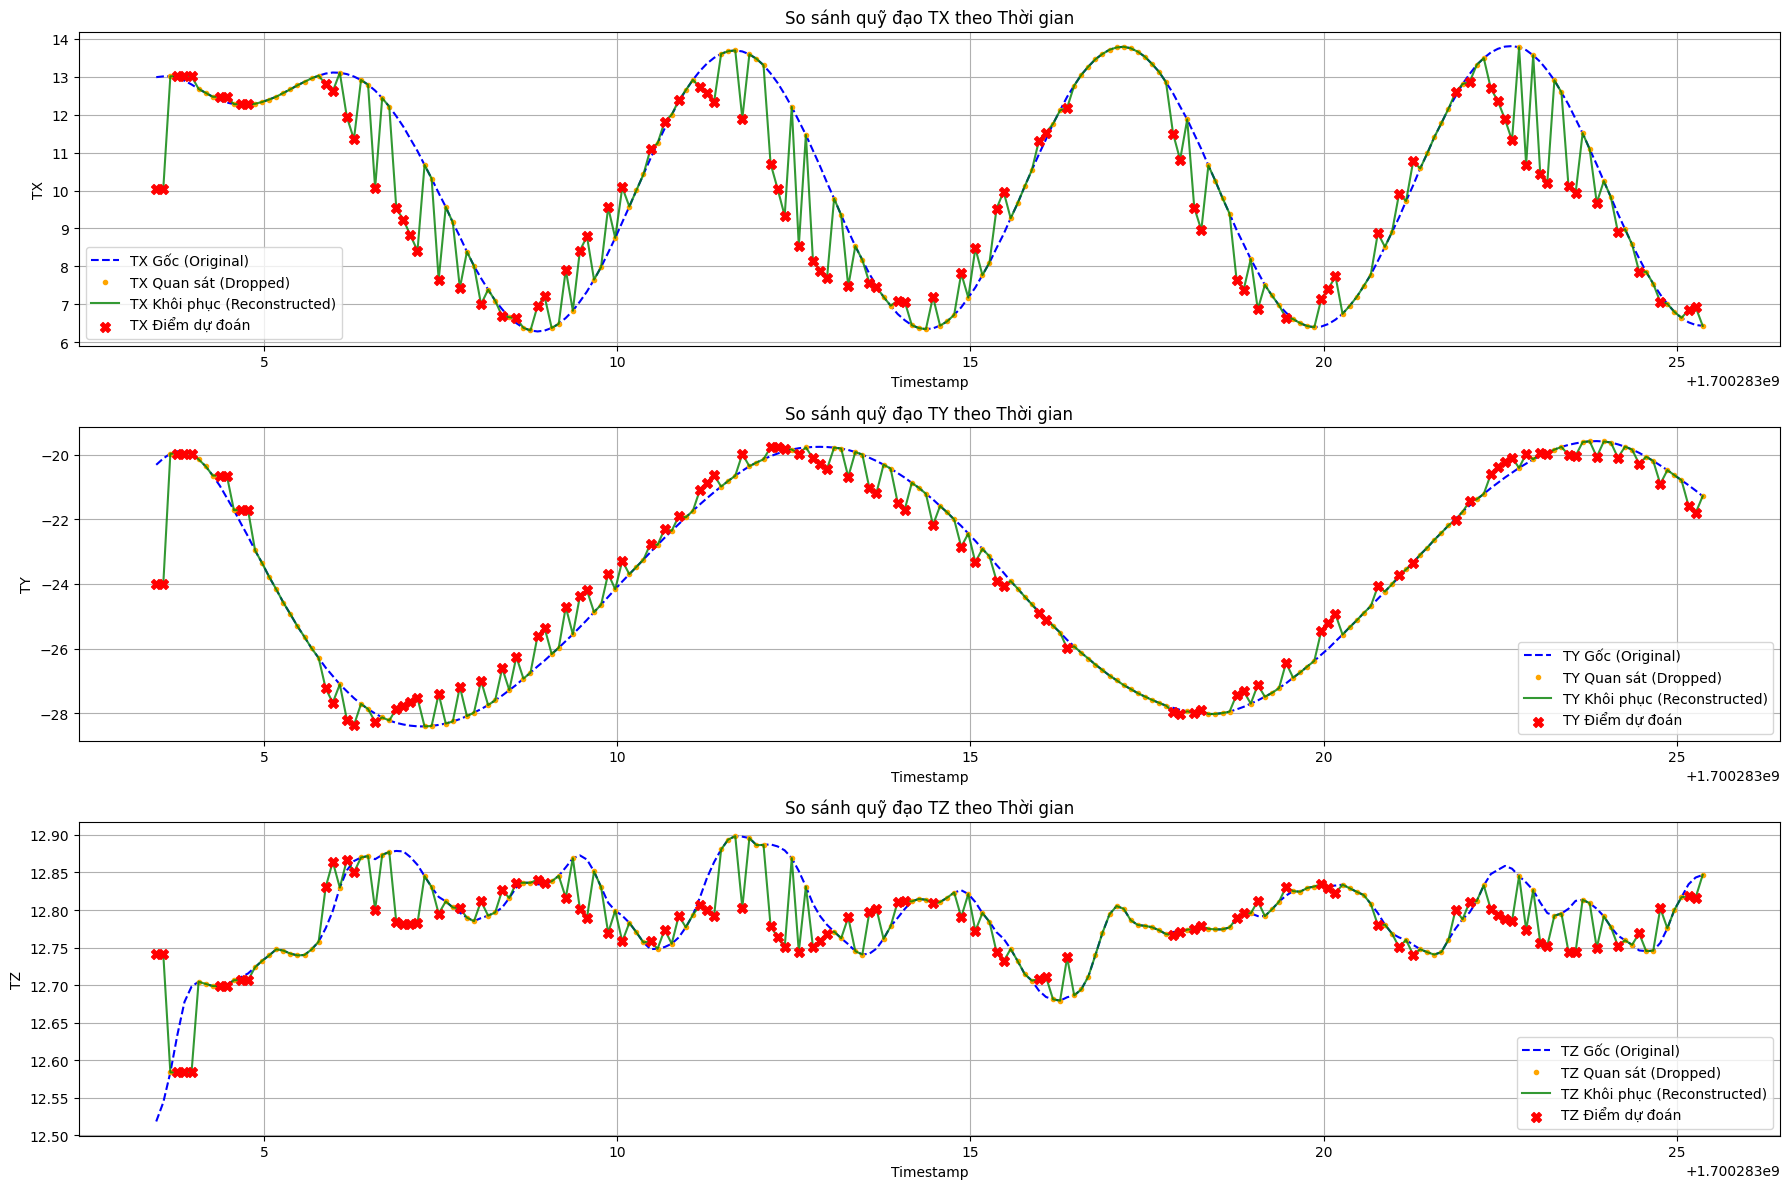

In [11]:
# 10. Trực quan hóa 2D
plt.figure(figsize=(18, 12)) # Tăng kích thước để chứa 3 subplot rõ ràng hơn

# Đồ thị cho TX
plt.subplot(3, 1, 1)
plt.plot(df_original_sorted['timestamp'], df_original_sorted['tx'], label='TX Gốc (Original)', color='blue', linestyle='--') # cite: 2
plt.plot(df_dropped_sorted['timestamp'], df_dropped_sorted['tx'], label='TX Quan sát (Dropped)', color='orange', marker='o', markersize=3, linestyle='') # cite: 1
plt.plot(df_reconstructed_final['timestamp'], df_reconstructed_final['tx'], label='TX Khôi phục (Reconstructed)', color='green', alpha=0.8)
if actual_missing_values and predicted_missing_values_for_eval:
    predicted_tx_values_for_plot = predicted_missing_values_np[:, 0]
    plt.scatter(actual_missing_timestamps_for_plot, predicted_tx_values_for_plot, color='red', label='TX Điểm dự đoán', s=50, zorder=5, marker='X')
plt.title('So sánh quỹ đạo TX theo Thời gian')
plt.xlabel('Timestamp')
plt.ylabel('TX')
plt.legend()
plt.grid(True)

# Đồ thị cho TY
plt.subplot(3, 1, 2)
plt.plot(df_original_sorted['timestamp'], df_original_sorted['ty'], label='TY Gốc (Original)', color='blue', linestyle='--') # cite: 2
plt.plot(df_dropped_sorted['timestamp'], df_dropped_sorted['ty'], label='TY Quan sát (Dropped)', color='orange', marker='o', markersize=3, linestyle='') # cite: 1
plt.plot(df_reconstructed_final['timestamp'], df_reconstructed_final['ty'], label='TY Khôi phục (Reconstructed)', color='green', alpha=0.8)
if actual_missing_values and predicted_missing_values_for_eval:
    predicted_ty_values_for_plot = predicted_missing_values_np[:, 1]
    plt.scatter(actual_missing_timestamps_for_plot, predicted_ty_values_for_plot, color='red', label='TY Điểm dự đoán', s=50, zorder=5, marker='X')
plt.title('So sánh quỹ đạo TY theo Thời gian')
plt.xlabel('Timestamp')
plt.ylabel('TY')
plt.legend()
plt.grid(True)

# Đồ thị cho TZ
plt.subplot(3, 1, 3)
plt.plot(df_original_sorted['timestamp'], df_original_sorted['tz'], label='TZ Gốc (Original)', color='blue', linestyle='--') # cite: 2
plt.plot(df_dropped_sorted['timestamp'], df_dropped_sorted['tz'], label='TZ Quan sát (Dropped)', color='orange', marker='o', markersize=3, linestyle='') # cite: 1
plt.plot(df_reconstructed_final['timestamp'], df_reconstructed_final['tz'], label='TZ Khôi phục (Reconstructed)', color='green', alpha=0.8)
if actual_missing_values and predicted_missing_values_for_eval:
    predicted_tz_values_for_plot = predicted_missing_values_np[:, 2]
    plt.scatter(actual_missing_timestamps_for_plot, predicted_tz_values_for_plot, color='red', label='TZ Điểm dự đoán', s=50, zorder=5, marker='X')
plt.title('So sánh quỹ đạo TZ theo Thời gian')
plt.xlabel('Timestamp')
plt.ylabel('TZ')
plt.legend()
plt.grid(True)

plt.tight_layout() # Điều chỉnh layout cho đẹp
plt.show()


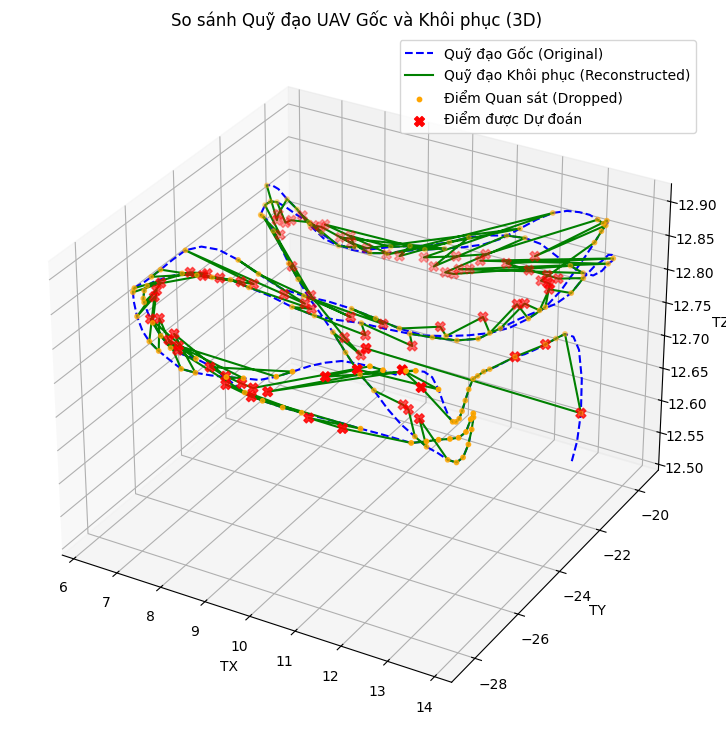


 DataFrame đã khôi phục (một phần):
      timestamp         tx         ty         tz
0  1.700283e+09  10.051143 -23.999845  12.741170
1  1.700283e+09  10.051143 -23.999845  12.741170
2  1.700283e+09  13.014602 -19.972520  12.583942
3  1.700283e+09  13.014602 -19.972520  12.583942
4  1.700283e+09  13.014602 -19.972520  12.583942


In [12]:
# 11. Trực quan hóa 3D
fig3d = plt.figure(figsize=(12, 9))
ax3d = fig3d.add_subplot(111, projection='3d')

# Dữ liệu gốc (đã sắp xếp)
orig_x = df_original_sorted['tx'].values # cite: 2
orig_y = df_original_sorted['ty'].values # cite: 2
orig_z = df_original_sorted['tz'].values # cite: 2
ax3d.plot(orig_x, orig_y, orig_z, label='Quỹ đạo Gốc (Original)', color='blue', linestyle='--')

# Dữ liệu đã khôi phục
recon_x = df_reconstructed_final['tx'].values
recon_y = df_reconstructed_final['ty'].values
recon_z = df_reconstructed_final['tz'].values
ax3d.plot(recon_x, recon_y, recon_z, label='Quỹ đạo Khôi phục (Reconstructed)', color='green')

# Dữ liệu quan sát (bị thiếu) - vẽ dạng điểm
dropped_x = df_dropped_sorted['tx'].values # cite: 1
dropped_y = df_dropped_sorted['ty'].values # cite: 1
dropped_z = df_dropped_sorted['tz'].values # cite: 1
ax3d.scatter(dropped_x, dropped_y, dropped_z, label='Điểm Quan sát (Dropped)', color='orange', s=10)

# Đánh dấu các điểm được dự đoán (là các điểm thiếu)
if actual_missing_values and predicted_missing_values_for_eval:
    predicted_points_x = predicted_missing_values_np[:, 0]
    predicted_points_y = predicted_missing_values_np[:, 1]
    predicted_points_z = predicted_missing_values_np[:, 2]
    ax3d.scatter(predicted_points_x, predicted_points_y, predicted_points_z, 
               color='red', label='Điểm được Dự đoán', s=50, depthshade=True, marker='X')


ax3d.set_xlabel('TX')
ax3d.set_ylabel('TY')
ax3d.set_zlabel('TZ')
ax3d.set_title('So sánh Quỹ đạo UAV Gốc và Khôi phục (3D)')
ax3d.legend()
plt.grid(True)
plt.show()

print("\n DataFrame đã khôi phục (một phần):")
print(df_reconstructed_final[['timestamp'] + features].head())